### Imports

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
from sklearn.impute import KNNImputer

### Configuration

In [28]:
EXPERIMENT = "tara"
MODE = "test"
ACTIVITIES = ["relaxing", "eating", "walking", "studying"]
simple_distance_based_outlier_columns = [
    'accel_z', 'accel_y', 'accel_x',
    'gyro_z', 'gyro_y', 'gyro_x',
    'magne_z', 'magne_y', 'magne_x',
]
local_outlier_factor_columns = [
    'gps_altitude', 'gps_latitude', 'gps_longitude',
    'gravity_z', 'gravity_y', 'gravity_x',
    'bar_relativeAltitude', 'bar_pressure',
    'ori_qz', 'ori_qy', 'ori_qx', 'ori_qw'
]

def print_missing_values_percentages(dataset: pd.DataFrame):
    nan_percentages_per_column = []
    for column in dataset.columns:
        
        nan_values = dataset[column].isnull().sum()
        
        total_values = dataset.shape[0]
        
        percentages = (nan_values / total_values) * 100
        
        nan_percentages_per_column.append(
            percentages
        )

    sns.barplot(y=nan_percentages_per_column, x=dataset.columns)
    plt.xticks(rotation=90, size=6)
    plt.tight_layout()
    plt.show()

### Data inputation (Interpolation)

In [29]:
dataset: pd.DataFrame = pd.read_csv(f"state/{EXPERIMENT}_{MODE}_outliers_removed.csv")
dataset

,accel_z,accel_y,accel_x,gyro_z,gyro_y,gyro_x,gravity_z,gravity_y,gravity_x,ori_qz,...,bar_relativeAltitude,bar_pressure,gps_altitude,gps_latitude,gps_longitude,time,walking,relaxing,eating,studying
0,-0.023840,0.018390,0.008858,-0.054503,-0.005479,0.011691,-7.563114,-5.831582,-2.216261,0.663099,...,0.015858,1018.030701,40.507936,52.047900,4.382954,2023-06-16 15:39:53.073135400,1,0,0,0
1,0.002951,0.022089,-0.041490,-0.070068,0.088273,-0.000520,-7.004715,-6.675822,-1.343320,0.653123,...,0.026424,1018.029251,40.643834,52.047898,4.382956,2023-06-16 15:39:54.073135400,1,0,0,0
2,0.083199,-0.117540,0.250466,0.099236,-0.050622,-0.041580,-7.546371,-6.011996,-1.740925,0.642579,...,NaN,1018.027916,40.755786,52.047895,4.382956,2023-06-16 15:39:55.073135400,1,0,0,0
3,-0.024142,-0.041310,-0.124078,0.268303,0.292325,0.254841,-7.262949,-6.160909,-2.257083,0.731410,...,NaN,1018.026657,40.815552,52.047892,4.382956,2023-06-16 15:39:56.073135400,1,0,0,0
4,-0.343633,0.325876,0.097991,-0.121707,-0.284418,-0.060837,-6.545389,-6.867339,-2.387059,0.749090,...,NaN,1018.028030,40.865129,52.047893,4.382956,2023-06-16 15:39:57.073135400,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3540,-0.027468,-0.002052,-0.012776,0.062467,0.000044,-0.000010,-9.806233,0.083322,0.035022,-0.157359,...,NaN,1017.307434,NaN,NaN,NaN,2023-06-16 16:38:53.073135400,0,0,0,1
3541,-0.029051,0.008580,0.018632,0.031754,-0.000316,-0.000033,NaN,0.079065,0.040456,-0.117536,...,NaN,1017.307434,NaN,NaN,NaN,2023-06-16 16:38:54.073135400,0,0,0,1
3542,-0.028269,0.002606,0.002662,-0.000234,-0.000159,0.000208,NaN,0.082902,0.039185,-0.113216,...,NaN,1017.306366,NaN,NaN,NaN,2023-06-16 16:38:55.073135400,0,0,0,1
3543,-0.028832,0.002296,0.002630,0.023920,0.000002,-0.000178,NaN,0.083961,0.039061,-0.108622,...,NaN,NaN,NaN,NaN,NaN,2023-06-16 16:38:56.073135400,0,0,0,1


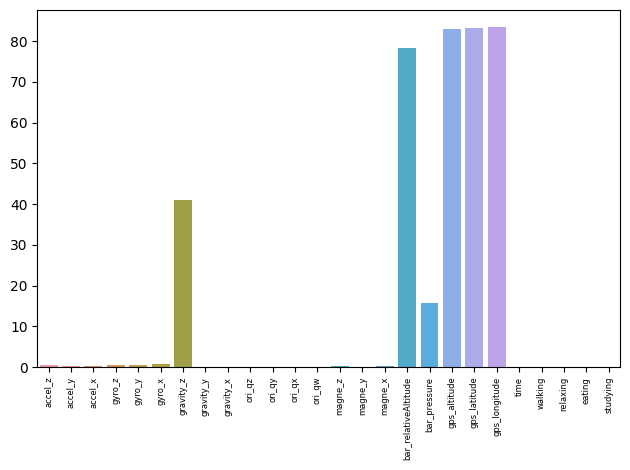

In [30]:
print_missing_values_percentages(dataset)

In [31]:
continuous_features = [
    'accel_z', 'accel_y', 'accel_x',
    'gyro_z', 'gyro_y', 'gyro_x',
    'ori_qz', 'ori_qy', 'ori_qx', 'ori_qw',
    'gps_altitude', 'gps_latitude', 'gps_longitude'
]
dataset[continuous_features] = dataset[continuous_features].interpolate(method='linear', axis=0)

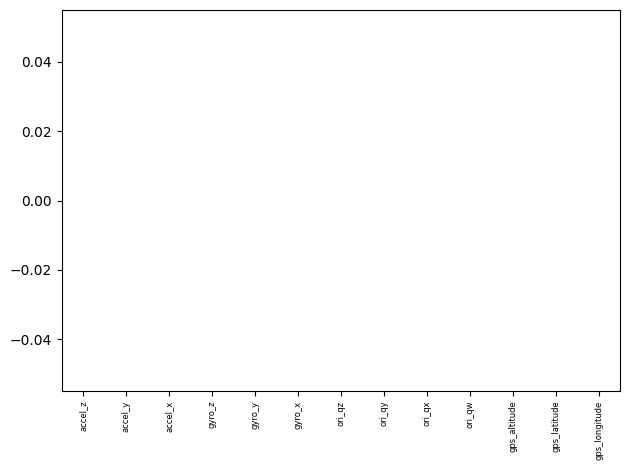

In [32]:
print_missing_values_percentages(dataset[continuous_features])

### Data inputation (KNN)

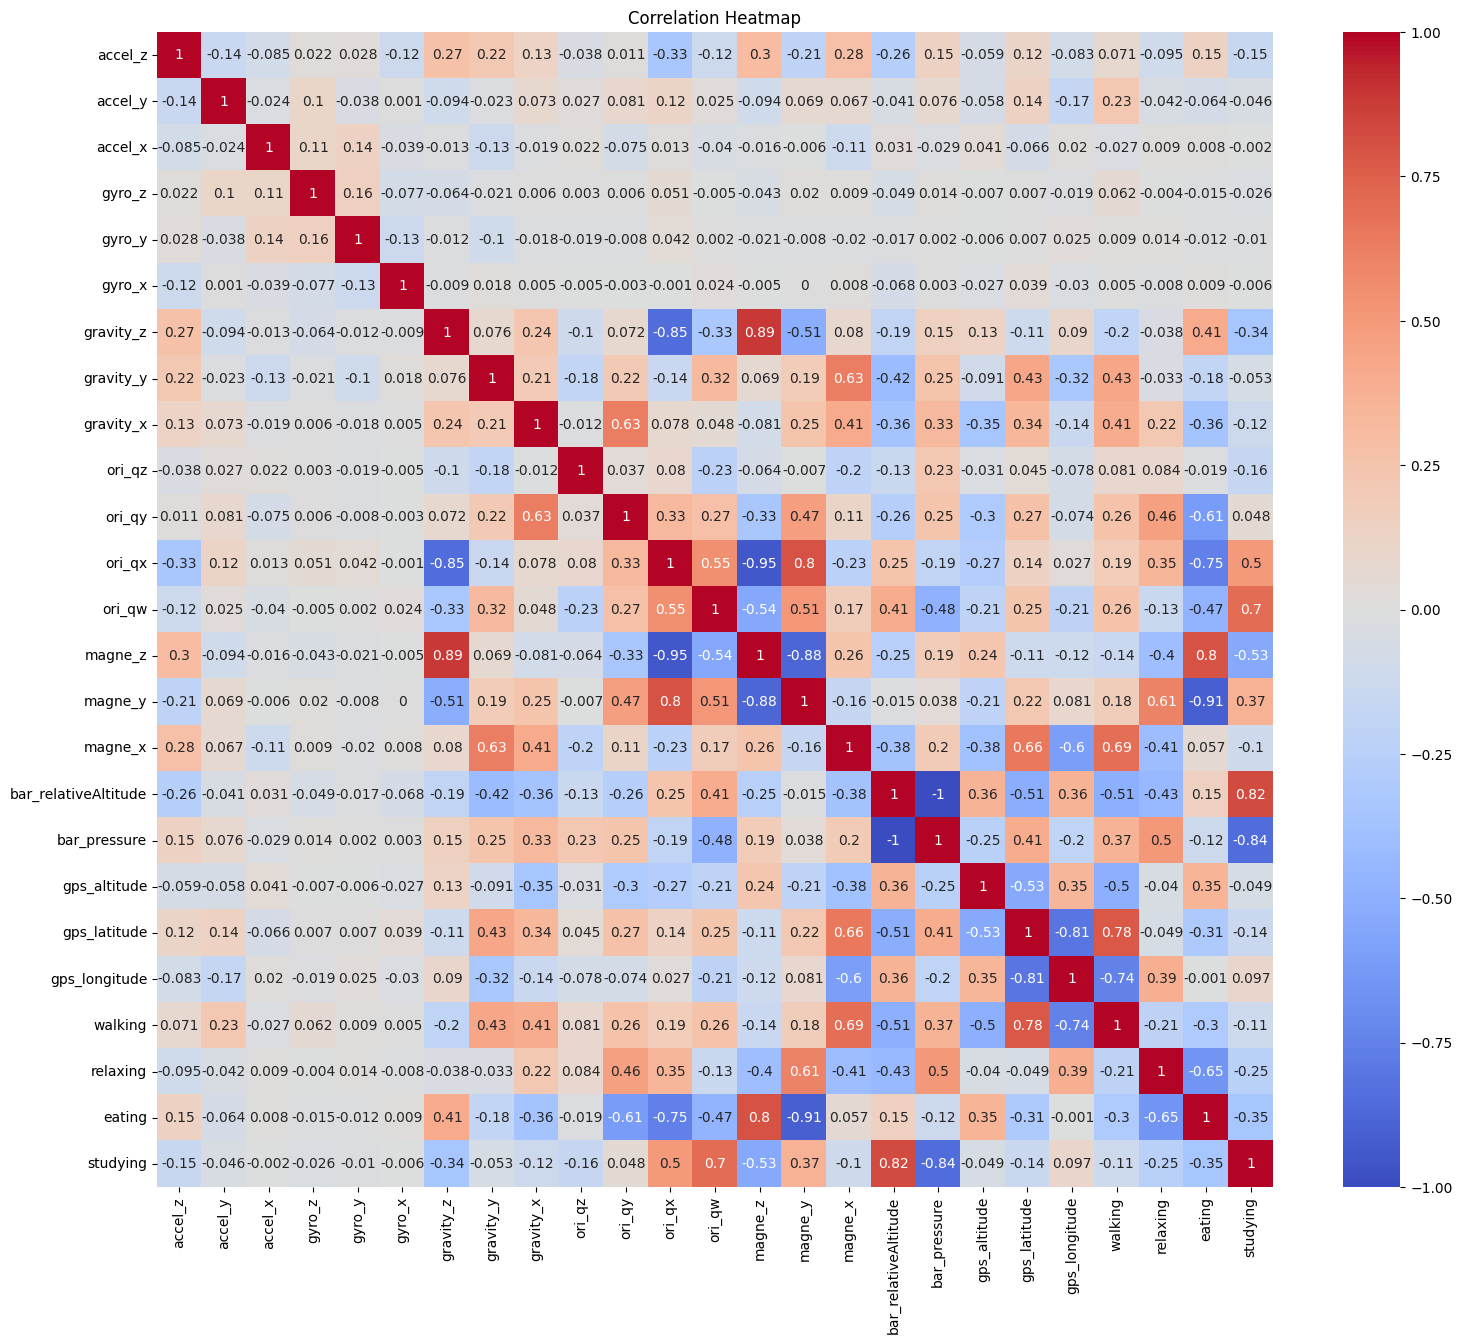

In [33]:
corr_matrix = dataset[0:-4].corr().round(3)
plt.figure(figsize=(18, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Set the title and display the plot
plt.title('Correlation Heatmap')
plt.show()

In [34]:
knn_impute = [
    'magne_z', 'magne_y', 'magne_x',
    'bar_relativeAltitude','bar_pressure',
    'gravity_z', 'gravity_y', 'gravity_x'
]

for x in knn_impute:
    selected_features = corr_matrix[corr_matrix[x] > 0.2].index.tolist()
    imputation_columns = selected_features + [x]
    imputation_df = dataset[imputation_columns]
    imputer = KNNImputer(n_neighbors=5)
    imputed_data = imputer.fit_transform(imputation_df)
    dataset[x] = imputed_data[:, -1]


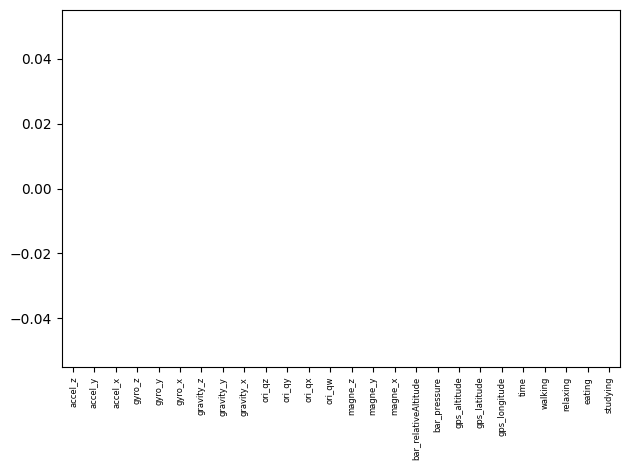

In [35]:
# saving the state for faster further experimentation
print_missing_values_percentages(dataset)
dataset.to_csv(f"state/{EXPERIMENT}_{MODE}_interpolated.csv", index=False)